In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=5bde61fdafe008f2f538cc25849f866fbd79af9f5d0542122bcf5b047937b73b
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 7.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.metrics import mean_squared_error, r2_score

import cvxpy as cvx

import pandas_datareader.data as web
import datetime

# Library with returns forecasting models
from PredictionModels import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import EfficientFrontier, objective_functions

**Building for Benchmark Markowitz**

In [ ]:
tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]

# Market capitalization in $Bln
caps = {
    'BTC-USD': 2101,
    'MA': 532,
    'ETH-USD': 307,
    'KO': 309,
    'BAC': 337,
    'GE': 250,
    'ADBE': 179,
    'MCD': 227,
    'DIS.MX': 202,
    'PEP': 180,
    'CVX': 239
}
start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'

In [ ]:
class Markowitz(DataStore):
    def __init__(self, tickers=[], start_date = '2010-01-01', end_date = '2025-04-20', period = '1d', caps = caps):
        super().__init__(tickers, start_date, end_date, period, caps=caps)
        self.exp_returns = self.data[1].mean() * 252 # If we have daily data
        self.cov = self.data[1].cov() * 252
        self.length = self.exp_returns.shape[0]
    def optimize(self):
        """
        The function optimizes the weights using Markowitz approach
        The function returns optimized weights for Markowitz portfolio
        """
        Q = np.array(self.cov)
        q = np.array(self.exp_returns)
        # Inequalities are written as Gx <= h
        G = np.diag(-1*np.ones(self.length), 0)
        h = np.zeros(self.length, dtype=int)
        # Equality constraints are written as Ax == b
        A = np.ones(self.length, dtype=int)
        b = np.array([1])
        # Defining and solving the quandratic problem
        x = cvx.Variable(self.length)
        prob = cvx.Problem(cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x),
            [G @ x <= h, A @ x == b])
        prob.solve()

        # Retrieving the weights
        x_values = x.value
        w = dict()
        for i in range(self.length):
            w[self.tickers[i]] = round(x_values[i], 4)

        return w

    def plot_weights(self):
        weights = self.optimize()
        fig = plt.figure(figsize=(15,5))
        plt.bar(weights.keys(), weights.values(), color='b', width=0.7)
        plt.title("Asset allocation by Markowitz model", y=1.05)
        plt.xlabel("Investment assets")
        plt.ylabel("Weights of assets in Markowitz portfolio")
        plt.grid()
        plt.show()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  11 of 11 completed


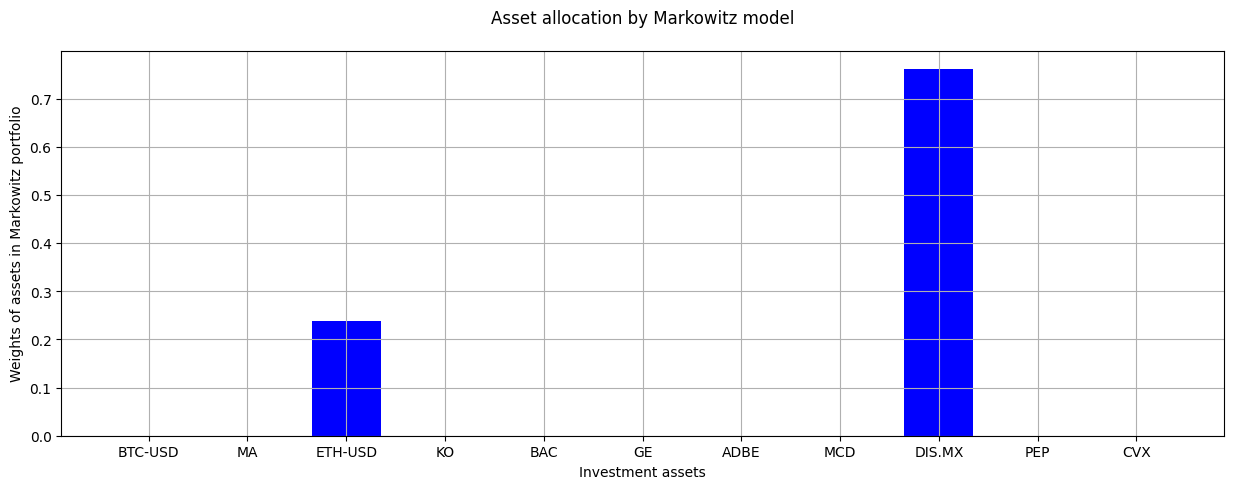

In [ ]:
# Instantiate the Markowitz model with given tickers, date range, frequency, and market caps
markowitz_model = Markowitz(tickers=tickers, start_date=start_date, end_date=end_date, period=period, caps=caps)
opt_weights = markowitz_model.optimize()
# Plot the resulting portfolio weights as a bar chart
markowitz_model.plot_weights()

**Build BlackLitterman**

In [ ]:
class BlackLitterman(DataStore):
    def __init__(self, tickers=[], start_date = '2010-01-01', end_date = '2025-04-20', period = '1d', caps=caps):
        super().__init__(tickers, start_date, end_date, period, caps=caps)

        # Loading additional data of 3-month US treasure rates to calculate excess returns
        self.tickers = tickers
        self.start_date = start_date
        self.end_data = end_date
        self.t_rates = web.DataReader("TB3MS", 'fred', start=self.start_date, end=self.end_date)
        self.t_rates.reset_index(inplace=True)
        self.t_rates.rename(columns={"DATE": "Date"}, inplace=True)
        self.t_rates['TB3MS'] = self.t_rates['TB3MS'] / 100
        self.data[1].reset_index(inplace=True)
        print(self.data[1])

        # Merging the assets data and T-bill data
        self.full_data = pd.merge(self.data[1], self.t_rates, how='left', on='Date')
        # Filling in the gaps
        self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
        self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(0.0015)
        # Converting the rates into 1 day rate by dividing by 90 days
        self.full_data['TB3MS'] = self.full_data['TB3MS'] / 90

        # Dividing the data into treasury returns and other assets returns
        self.assets_returns = self.full_data[self.tickers]
        self.treasury_rate = self.full_data["TB3MS"]

    def equil_weights(self):
        """
            The function returns equilibrium weights calculated using market capitalization of assets (Yahoo Finance)
        """
        asset_weights = pd.DataFrame(self.caps.values(), index=self.caps.keys(), columns=['Cap'])
        asset_weights['Weights'] = asset_weights['Cap'].apply(lambda x: x / asset_weights['Cap'].sum())
        return asset_weights

    def implied_equil_returns(self):
        """

        """
        assets_weights = self.equil_weights()
        excess_returns = self.assets_returns.subtract(self.treasury_rate, axis=0)
        # Calculation of excess returns covariance matrix
        covar = excess_returns.cov() * 252
                # Risk-aversion parameter
        risk_aversion = 10
        print("risk_aversion=",risk_aversion)

        return self.implied_function(risk_aversion, covar, assets_weights['Weights'])


    def implied_function(self, risk_avers_param, sig, weights):
        """
            The function calculates equlibrium market returns

            Arg:
                - risk_avers_param (float) - risk-aversion parameter
                - sig (np.array) - covariance matrix of excess returns
                - weights (pd.Series) - equilibrium market weights
            return: equlibrium market returns
        """

        return risk_avers_param * sig.dot(weights).squeeze()


    def views_function(self):
        pass

    def function(self, predictions: dict, method: str):
        """
        The function returns the views matrix based on predictions
        """
        pass


    def function1(self):
        """
        The function does some!
        """

        pass


    def consolid_preds(self):
        """
        The function stores expected returns for each asset based on different models predictions
        """
        self.q_matrix = np.zeros(len(self.tickers))

        # Container of forecasts
        preds = np.zeros((10, len(self.tickers)))

        for i, ticker in enumerate(self.tickers):
            # Initializing the prediction models

            # DesicionTreeRegressor
            des_tree = DesicionTreeRegressorPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )
            # LogisticRegression
            log_reg = LinearRegressionPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            svr_reg = SVRPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )


            lstm_reg = LSTMPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )


            cnn_reg = CNNPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            tf_reg = TransformerPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            xgb_reg = XGBoostPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            mlp_reg = MLPPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            rr_reg = RidgeRegressionPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            wae_reg = WeightedAverageEnsemble(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            # Making forecasts
            preds[0, i] = des_tree.make_forecast()[0]
            preds[1, i] = log_reg.make_forecast()[0]
            preds[2, i] = svr_reg.make_forecast()[0]
            preds[3, i] = lstm_reg.make_forecast()[0]
            preds[4, i] = cnn_reg.make_forecast()[0]

            preds[5, i] = tf_reg.make_forecast()[0]
            preds[6, i] = xgb_reg.make_forecast()[0]
            preds[7, i] = mlp_reg.make_forecast()[0]
            preds[8, i] = rr_reg.make_forecast()[0]
            preds[9, i] = wae_reg.make_forecast()[0]




        return preds



**Build Black-Litterman for Benchmark**

In [ ]:
tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]

# Market capitalization in $Bln
caps = {
    'BTC-USD': 2101,
    'MA': 532,
    'ETH-USD': 307,
    'KO': 309,
    'BAC': 337,
    'GE': 250,
    'ADBE': 179,
    'MCD': 227,
    'DIS.MX': 202,
    'PEP': 180,
    'CVX': 239
}
start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'

bl = BlackLitterman(tickers, start_date, end_date, period)
# Generate consolidated return predictions from all models
forecasts = bl.consolid_preds()
# Compute the mean predicted return for each ticker across all models (used as "views")
mean_preds = forecasts.mean(axis=0)
# Assign the mean predictions to a pandas Series Q, indexed by ticker names (the "view" vector)
Q = pd.Series(mean_preds, index=tickers)

# Scale the predicted returns down (e.g., for more conservative views)
Q = Q * 0.5


P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)

# Estimate the annualized covariance matrix of asset returns (S)
S           = bl.assets_returns.cov() * 252
# Calculate implied equilibrium returns
prior       = bl.implied_equil_returns()   # π
# Set confidence levels for each view
confidences = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]






# Creating model
bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


rets = bl2.bl_returns() # Calculating Expected returns
ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
weights1 = ef.clean_weights() # Cleaning weights
weights1 # Printing weights

[*********************100%***********************]  11 of 11 completed
<ipython-input-12-609006600094>:35: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio1 = (prices_portfolio1.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)


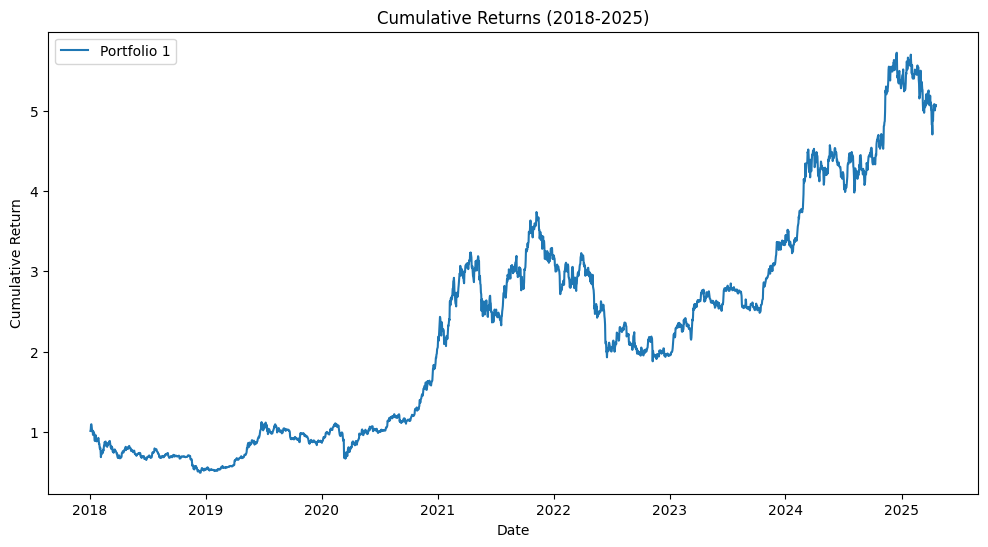

In [ ]:
# Define the portfolios
portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]





# Download historical data from Yahoo Finance
start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'
portfolios = {'Portfolio 1': portfolio1}

# Fetch weekly adjusted close prices
weekly_data = {}
for name, tickers in portfolios.items():
    data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
    weekly_data[name] = data


prices_portfolio1 = weekly_data['Portfolio 1']

returns_portfolio1 = (prices_portfolio1.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)


# Calculate cumulative returns for each portfolio
cumulative_returns_weighted = {}
cumulative_returns_weighted['Portfolio 1'] = (1 + returns_portfolio1).cumprod()


# Plot cumulative returns with manual weights
plt.figure(figsize=(12, 6))
for name, cumulative_return in cumulative_returns_weighted.items():
    plt.plot(cumulative_return, label=name)
plt.title('Cumulative Returns (2018-2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

**Backtesting and Test Several Strategies for Opmitizing Portfolio 3 Months, 6 Months, and 12 Months Rebalancing**

In [ ]:
weekly_dates = pd.date_range(
    start='2018-01-01',
    end='2025-04-20',
    freq='3M'
).strftime('%Y-%m-%d').tolist()


i = 0
prices_portfolio = {}
returns_portfolio = {}
returns_portfolio_2_ = {}
returns_portfolio_3_ = {}
returns_portfolio_4_ = {}
for k in range(len(weekly_dates) - 2):

  i = i + 1
  tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]


  start_date = weekly_dates[k]
  end_date = weekly_dates[k+1]
  period = '1d'

  print(start_date,end_date)


  bl = BlackLitterman(tickers, start_date, end_date, period)

  forecasts = bl.consolid_preds()
  mean_preds = forecasts.mean(axis=0)
  Q = pd.Series(mean_preds, index=tickers)

  Q = Q * 0.5

  P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)


  S           = bl.assets_returns.cov() * 252
  prior       = bl.implied_equil_returns()   # π
  confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# Creating model
  bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


  rets = bl2.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights1 = ef.clean_weights() # Cleaning weights
  weights1 # Printing weights

    # Define the portfolios
  portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'XOM', # Exxon Mobil Corporation
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'CVX' # Chevron
]
  # Download historical data from Yahoo Finance
  start_date = weekly_dates[k+1]
  end_date = weekly_dates[k+2]
  period = '1d'
  portfolios = {'Portfolio 1': portfolio1}


  # Fetch weekly adjusted close prices
  weekly_data = {}
  for name, tickers in portfolios.items():
      data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
      weekly_data[name] = data

  prices_portfolio = weekly_data['Portfolio 1']
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)



dfs2 = [returns_portfolio[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# # Concatenate them side by side (columns)
combined_df2 = pd.concat(dfs2, axis=0)



# #4 Months -----------


# weekly_dates = pd.date_range(
#     start='2018-01-01',
#     end='2025-04-20',
#     freq='4M'
# ).strftime('%Y-%m-%d').tolist()


# i = 0
# prices_portfolio = {}

# for k in range(len(weekly_dates) - 2):

#   i = i + 1
#   tickers = [
#     'BTC-USD', # Bitcoin
#     'MA', # Mastercard
#     'ETH-USD', # Etherium
#     'KO', # Coca-Cola
#     'BAC', # Bank of America
#     'GE', # General Electric
#     'ADBE', # Adobe
#     'MCD', # McDonald
#     'DIS.MX', # The Walt Disney Company
#     'PEP', # Pepsico
#     'CVX', # Chevron
# ]


#   start_date = weekly_dates[k]
#   end_date = weekly_dates[k+1]
#   period = '1d'

#   print(start_date,end_date)


#   bl = BlackLitterman(tickers, start_date, end_date, period)

#   forecasts = bl.consolid_preds()
#   mean_preds = forecasts.mean(axis=0)
#   Q = pd.Series(mean_preds, index=tickers)

#   Q = Q * 0.5

#   P = pd.DataFrame(
#     np.eye(len(tickers)),
#     index=tickers,
#     columns=tickers
# )


#   S           = bl.assets_returns.cov() * 252
#   prior       = bl.implied_equil_returns()   # π
#   confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# # Creating model
#   bl2 = BlackLittermanModel(S, # Covariance Matrix
#                          pi = prior, # Prior expected returns
#                          Q = Q, # Vector of views
#                          P = P, # Matrix mapping the views
#                          omega = 'idzorek', # Confidence levels in %
#                          view_confidences = confidences) # Confidences


#   rets = bl2.bl_returns() # Calculating Expected returns
#   ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

#   ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
#   weights1 = ef.clean_weights() # Cleaning weights
#   weights1 # Printing weights

#     # Define the portfolios
#   portfolio1 = [
#     'BTC-USD', # Bitcoin
#     'MA', # Mastercard
#     'ETH-USD', # Etherium
#     'KO', # Coca-Cola
#     'BAC', # Bank of America
#     'GE', # General Electric
#     'XOM', # Exxon Mobil Corporation
#     'MCD', # McDonald
#     'DIS.MX', # The Walt Disney Company
#     'PG.MX', # The Procter & Gamble Company
#     'CVX' # Chevron
# ]
#   # Download historical data from Yahoo Finance
#   start_date = weekly_dates[k+1]
#   end_date = weekly_dates[k+2]
#   period = '1d'
#   portfolios = {'Portfolio 1': portfolio1}


#   # Fetch weekly adjusted close prices
#   weekly_data = {}
#   for name, tickers in portfolios.items():
#       data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
#       weekly_data[name] = data

#   prices_portfolio = weekly_data['Portfolio 1']
#   returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)

# dfs3 = [returns_portfolio_2_[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# # Concatenate them side by side (columns)
# combined_df3 = pd.concat(dfs3, axis=0)



# #5 Months -----------


# weekly_dates = pd.date_range(
#     start='2018-01-01',
#     end='2025-04-20',
#     freq='5M'
# ).strftime('%Y-%m-%d').tolist()


# i = 0
# prices_portfolio = {}

# for k in range(len(weekly_dates) - 2):

#   i = i + 1
#   tickers = [
#     'BTC-USD', # Bitcoin
#     'MA', # Mastercard
#     'ETH-USD', # Etherium
#     'KO', # Coca-Cola
#     'BAC', # Bank of America
#     'GE', # General Electric
#     'ADBE', # Adobe
#     'MCD', # McDonald
#     'DIS.MX', # The Walt Disney Company
#     'PEP', # Pepsico
#     'CVX', # Chevron
# ]


#   start_date = weekly_dates[k]
#   end_date = weekly_dates[k+1]
#   period = '1d'

#   print(start_date,end_date)


#   bl = BlackLitterman(tickers, start_date, end_date, period)

#   forecasts = bl.consolid_preds()
#   mean_preds = forecasts.mean(axis=0)
#   Q = pd.Series(mean_preds, index=tickers)

#   Q = Q * 0.5

#   P = pd.DataFrame(
#     np.eye(len(tickers)),
#     index=tickers,
#     columns=tickers
# )


#   S           = bl.assets_returns.cov() * 252
#   prior       = bl.implied_equil_returns()   # π
#   confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# # Creating model
#   bl2 = BlackLittermanModel(S, # Covariance Matrix
#                          pi = prior, # Prior expected returns
#                          Q = Q, # Vector of views
#                          P = P, # Matrix mapping the views
#                          omega = 'idzorek', # Confidence levels in %
#                          view_confidences = confidences) # Confidences


#   rets = bl2.bl_returns() # Calculating Expected returns
#   ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

#   ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
#   weights1 = ef.clean_weights() # Cleaning weights
#   weights1 # Printing weights

#     # Define the portfolios
#   portfolio1 = [
#     'BTC-USD', # Bitcoin
#     'MA', # Mastercard
#     'ETH-USD', # Etherium
#     'KO', # Coca-Cola
#     'BAC', # Bank of America
#     'GE', # General Electric
#     'XOM', # Exxon Mobil Corporation
#     'MCD', # McDonald
#     'DIS.MX', # The Walt Disney Company
#     'PG.MX', # The Procter & Gamble Company
#     'CVX' # Chevron
# ]
#   # Download historical data from Yahoo Finance
#   start_date = weekly_dates[k+1]
#   end_date = weekly_dates[k+2]
#   period = '1d'
#   portfolios = {'Portfolio 1': portfolio1}


#   # Fetch weekly adjusted close prices
#   weekly_data = {}
#   for name, tickers in portfolios.items():
#       data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
#       weekly_data[name] = data

#   prices_portfolio = weekly_data['Portfolio 1']
#   returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)




# dfs4 = [returns_portfolio_3_[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# # Concatenate them side by side (columns)
# combined_df4 = pd.concat(dfs4, axis=0)


#6 Months -----------


weekly_dates = pd.date_range(
    start='2018-01-01',
    end='2025-04-20',
    freq='6M'
).strftime('%Y-%m-%d').tolist()


i = 0


# We use (len(weekly_dates) - 2) in the loop because:
# - The last date in weekly_dates is close to or at the end date (2025-04-20).
# - We want to make a prediction for a period before the final interval ends,
#   so we exclude the last interval (can't make a prediction that needs data after 2025-04-20).
# - The second-to-last index (i.e., -2) ensures predictions use only available data.

for k in range(len(weekly_dates) - 2):

  i = i + 1
  tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]


  start_date = weekly_dates[k]
  end_date = weekly_dates[k+1]
  period = '1d'

  print(start_date,end_date)


  bl = BlackLitterman(tickers, start_date, end_date, period)

  forecasts = bl.consolid_preds()
  mean_preds = forecasts.mean(axis=0)
  Q = pd.Series(mean_preds, index=tickers)

  Q = Q * 0.5

  P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)

# Estimate the annualized covariance matrix of asset returns (S)
  S           = bl.assets_returns.cov() * 252
# Calculate implied equilibrium returns
  prior       = bl.implied_equil_returns()   # π
# Set confidence levels for each view (here, 0.5 for all assets)
  confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# Creating model
  bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


  rets = bl2.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights1 = ef.clean_weights() # Cleaning weights
  weights1 # Printing weights

    # Define the portfolios
  portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'XOM', # Exxon Mobil Corporation
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'CVX' # Chevron
]
  # Download historical data from Yahoo Finance
  start_date = weekly_dates[k+1]
  end_date = weekly_dates[k+2]
  period = '1d'
  portfolios = {'Portfolio 1': portfolio1}


  # Fetch weekly adjusted close prices
  weekly_data = {}
  for name, tickers in portfolios.items():
      data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
      weekly_data[name] = data

  prices_portfolio = weekly_data['Portfolio 1']
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)



dfs5 = [returns_portfolio_4_[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# Concatenate them side by side (columns)
combined_df5 = pd.concat(dfs5, axis=0)




#12 Months -----------


weekly_dates = pd.date_range(
    start='2018-01-01',
    end='2025-04-20',
    freq='12M'
).strftime('%Y-%m-%d').tolist()


i = 0
prices_portfolio = {}
returns_portfolio_5_= {}
for k in range(len(weekly_dates) - 2):

  i = i + 1
  tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]


  start_date = weekly_dates[k]
  end_date = weekly_dates[k+1]
  period = '1d'

  print(start_date,end_date)


  bl = BlackLitterman(tickers, start_date, end_date, period)

  forecasts = bl.consolid_preds()
  mean_preds = forecasts.mean(axis=0)
  Q = pd.Series(mean_preds, index=tickers)

  Q = Q * 0.5

  P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)


  S           = bl.assets_returns.cov() * 252
  prior       = bl.implied_equil_returns()   # π
  confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# Creating model
  bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


  rets = bl2.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights1 = ef.clean_weights() # Cleaning weights
  weights1 # Printing weights

    # Define the portfolios
  portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'XOM', # Exxon Mobil Corporation
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'CVX' # Chevron
]
  # Download historical data from Yahoo Finance
  start_date = weekly_dates[k+1]
  end_date = weekly_dates[k+2]
  period = '1d'
  portfolios = {'Portfolio 1': portfolio1}


  # Fetch weekly adjusted close prices
  weekly_data = {}
  for name, tickers in portfolios.items():
      data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
      weekly_data[name] = data

  prices_portfolio = weekly_data['Portfolio 1']
  returns_portfolio_5_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)



dfs6 = [returns_portfolio_5_[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# Concatenate them side by side (columns)
combined_df6 = pd.concat(dfs6, axis=0)

**Prepare for Back Testing**

In [ ]:
# Define the portfolios
portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]


# Convert the optimized weights (from Markowitz model) to float values for calculation
d_float = {k: float(v) for k, v in opt_weights.items()}

# Download historical data from Yahoo Finance
start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'
portfolios = {'Portfolio 1': portfolio1}

# Fetch weekly adjusted close prices
weekly_data = {}
for name, tickers in portfolios.items():
    data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
    weekly_data[name] = data

# Extract price data for 'Portfolio 1'
prices_portfolio1 = weekly_data['Portfolio 1']

# Calculate daily returns for each asset, then multiply by portfolio weights (d_float)
# Sum across assets to get the daily portfolio return (i.e., Markowitz backtesting)
returns_portfolio_3  = (prices_portfolio1.pct_change().dropna() * pd.Series(d_float)).sum(axis=1)


**Calculate cumulative returns**

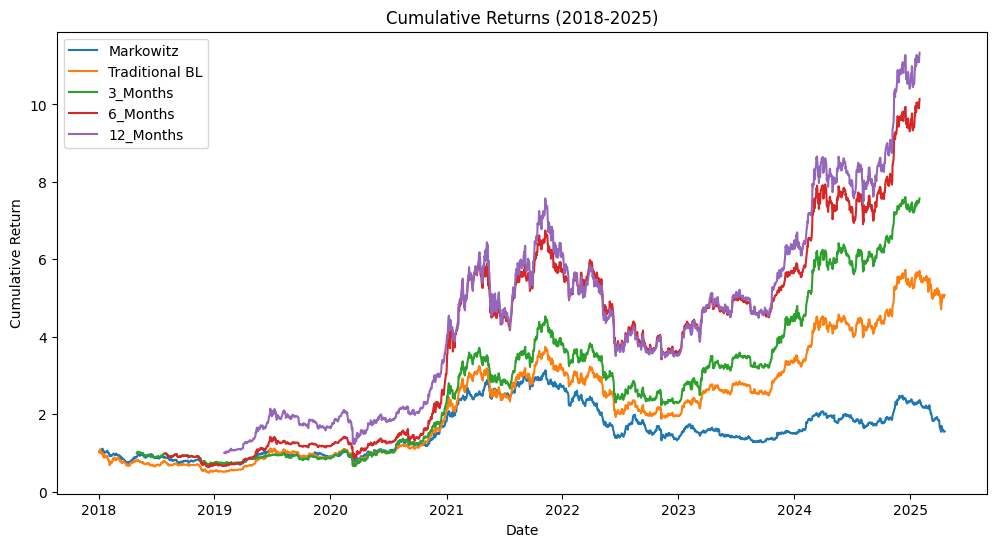

In [ ]:
# Calculate cumulative returns for each portfolio
cumulative_returns_weighted = {}
cumulative_returns_weighted['Markowitz'] = (1 + returns_portfolio_3).cumprod()
cumulative_returns_weighted['Traditional BL'] = (1 + returns_portfolio1).cumprod()
cumulative_returns_weighted['3_Months'] = (1 + combined_df2).cumprod()
# cumulative_returns_weighted['4_Months'] = (1 + combined_df3).cumprod()
# cumulative_returns_weighted['5_Months'] = (1 + combined_df4).cumprod()
cumulative_returns_weighted['6_Months'] = (1 + combined_df5).cumprod()
cumulative_returns_weighted['12_Months'] = (1 + combined_df6).cumprod()


# Plot cumulative returns with manual weights
plt.figure(figsize=(12, 6))
for name, cumulative_return in cumulative_returns_weighted.items():
    plt.plot(cumulative_return, label=name)
plt.title('Cumulative Returns (2018-2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

**Compare Across 4 metrics: Annualized Volatility, Sharpe Ratio, Sortino Ratio, Maximum Drawdown**

In [ ]:
annualized_volatility_weighted = {}
sharpe_ratio_weighted = {}
max_drawdown_weighted = {}
sortino_ratio_weighted = {}



for name, returns in cumulative_returns_weighted.items():
    # Calculate daily returns from cumulative returns
    daily_returns = returns.pct_change().dropna()

    # Annualized volatility
    vol = daily_returns.std() * np.sqrt(52)
    annualized_volatility_weighted[name] = vol

    # Sharpe Ratio (assuming risk-free rate = 0)
    sr = (daily_returns.mean() * 52) / vol
    sharpe_ratio_weighted[name] = sr

    downside_returns = daily_returns[daily_returns < 0]
    downside_std = downside_returns.std() * np.sqrt(52)
    mean_return = daily_returns.mean() * 52
    sortino_ratio = mean_return / downside_std if downside_std != 0 else np.nan
    sortino_ratio_weighted[name] = sortino_ratio

    running_max = returns.cummax()
    drawdown = (returns / running_max) - 1
    max_drawdown = drawdown.min()
    max_drawdown_weighted[name] = max_drawdown



# Print out performance metrics
for name in cumulative_returns_weighted.keys():
    print(f"{name} Performance Metrics:")
    print(f"Annualized Volatility: {annualized_volatility_weighted[name]:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio_weighted[name]:.2f}")
    print(f"Sortino Ratio: {sortino_ratio_weighted[name]:.2f}")
    print(f"Maximum Drawdown: {max_drawdown_weighted[name]:.2%}")

    print("\n")

Markowitz Performance Metrics:
Annualized Volatility: 12.66%
Sharpe Ratio: 0.13
Sortino Ratio: 0.18
Maximum Drawdown: -59.37%


Traditional BL Performance Metrics:
Annualized Volatility: 14.08%
Sharpe Ratio: 0.30
Sortino Ratio: 0.38
Maximum Drawdown: -55.36%


3_Months Performance Metrics:
Annualized Volatility: 13.12%
Sharpe Ratio: 0.40
Sortino Ratio: 0.51
Maximum Drawdown: -50.73%


6_Months Performance Metrics:
Annualized Volatility: 14.11%
Sharpe Ratio: 0.43
Sortino Ratio: 0.56
Maximum Drawdown: -49.36%


12_Months Performance Metrics:
Annualized Volatility: 14.77%
Sharpe Ratio: 0.47
Sortino Ratio: 0.61
Maximum Drawdown: -54.36%




The results from our backtesting demonstrate that integrating Machine Learning and Deep learning models with Black-Litterman is significantly enhances portfolio performance across all evaluation metrics.

Key findings:


**Markowitz** had the lowest performance with smallest Sharpe Ratio, Highest maximum drawdown, and lowest cumulative return.

**Black-Litterman** model had better performance than Morkowitz across 4 metrics

**ML/DL models integrated with Black-Litterman** significantly outperformed traditional

Performance of the 6_month and 12_month rebalancing strategies is quite close

6_month model has a Sharpe Ratio of 0.43 and a Sortino Ratio of 0.56, while the 12_month model slightly better ahead with a Sharpe of 0.47 and Sortino of 0.61. However, the 6_month strategy has a smaller maximum drawdown at -49.36% compared to -54.36% for the 12_month.

